# Gaussian Processes



At the core of GP is the multivariate Gaussian distribution. GP uses the fact that any n-observations, $(x_1, …, x_n)$, in a data set is a point sampled from  an $n$-variate Gaussian distribution. GP defines prior over functions (Gaussian distributions), using a suitable kernel function. The training set is then used to obtain the posterior distribution from the prior. This is then used to obtain mean, standard deviation, etc for the test data.

The above systematic procedure makes GP a tractable framework for various machine learning problems. Predictions in GP are probabilistic - confidence interval etc. are the byproduct of the process. In some sense, GPs are a generalization of the Gaussian distributions. GP is a non-parametric approach, where we try to fit a data using all the functions! This is in contrast to methods where parameters are estimates. We start with a prior over all functions and then use a suitable kernel and the training data to obtain the posterior. Indeed, there are some conditions, like the function should be smooth and all. We explore this below. Lets first discussion the Gaussian distribution. 



## Multivariate Gaussian distribution
A multivariate Gaussian distribution is completely specified by its mean $\boldsymbol\mu$ and matrix of covariances  $\boldsymbol\Sigma$. 

For a $n$-dimensional vector $\boldsymbol X$, the distribution is written as

$$
\boldsymbol{X}\sim\mathcal{N}\left(\boldsymbol{\mu},\boldsymbol{\Sigma}\right).
$$

The covariance matrix is $n\times n$ for a n-variate Gaussian distribution, while the mean is a $n$-dimensional vector. Explicitly

$$
{\displaystyle {\boldsymbol {\mu }}=\operatorname {E} [\mathbf {X} ]},\qquad
{\displaystyle {\boldsymbol {\Sigma }}=:\operatorname {E} [(\mathbf {X} -{\boldsymbol {\mu }})(\mathbf {X} -{\boldsymbol {\mu }})^{\rm {T}}]=[\operatorname {Cov} [X_{i},X_{j}];1\leq i,j\leq k].} 
$$

In particular, the n-variate case is

$$
{\displaystyle f(\boldsymbol X\mid \boldsymbol\mu ,\boldsymbol\Sigma)={\frac {1}{\sqrt {(2\pi)^{n} |\Sigma|}}}\exp\Big\{-{\frac{1}{2} {(\boldsymbol X-\boldsymbol \mu )^T\,\boldsymbol\Sigma^{-1}\, (\boldsymbol X-\boldsymbol \mu ) }}}\Big\}.
$$


#### A bivariate normal would look like
$$
\begin{pmatrix}x_1 \\ x_2 \end{pmatrix} \sim \mathcal N\left\{ \begin{pmatrix}\mu_1 \\ \mu_2 \end{pmatrix},\begin{pmatrix}\sigma_{11} & \sigma_{12}\\ \sigma_{21} & \sigma_{22} \end{pmatrix}\right\}.
$$

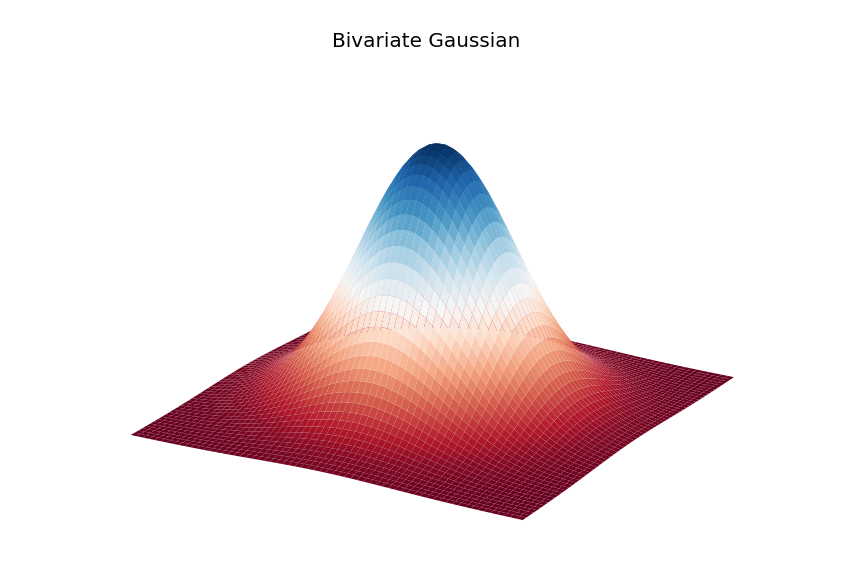

In [6]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm
f = plt.figure(num=None, figsize=(15, 10)); ax = f.add_subplot(1, 1, 1, projection='3d');

x, y = np.meshgrid(np.linspace(-4, 4, 64), np.linspace(-4, 4, 64));
r = np.sqrt(x**2 + y**2);  z = .5*(np.exp(-r*r/4)); 

ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0);
plt.axis('off');plt.title('Bivariate Gaussian', fontsize=20);

## Gaussian Processes Regression

Thus, we have joint probability distribution of many variables. Using Bayes theorem, it is possible to derive posterior for a set of test variables from prior constructed out of the training points. Let's assume that we have a training set $(y,x)$ and we want to predict $(y_*,x_*)$. So the joint probability will look like

$$
\begin{pmatrix}y \\ y_* \end{pmatrix} = \mathcal N\left\{ \begin{pmatrix}\mu \\ \mu_* \end{pmatrix},\begin{pmatrix}K & K_*\\ K_*^T & K_{**} \end{pmatrix}\right\}.
$$

Here $K$ is a kernel matrix given as

$$
K =   \begin{pmatrix} 
k(x_1, x_1) \quad k(x_1, x_2) \quad\ldots \quad k(x_1, x_n) \\
k(x_2, x_1) \quad k(x_2, x_2) \quad\ldots \quad k(x_2, x_n) \\ 
\vdots\quad\qquad \vdots\quad\qquad\vdots \quad\qquad\vdots \\
k(x_n, x_1) \quad k(x_n, x_2) \quad\ldots \quad k(x_n, x_n) 
\end{pmatrix},  
$$

where we choose $k(x, x')$ to be

$$
k(x, x') = \alpha_1\exp\left(-\tfrac{\alpha_2}{2}(x-x')^2\right).
$$

The above exponential choice of kernel function is popular as it has desirable properties:
* correlation of $f(x)$ and $f(x')$ is close to unity as $x\rightarrow x'$. So neighbours are similar for a smooth functuon.
* distant points can $see$ each other such that $x\gg x' \implies k(x, x')\sim0$.




So we have a prior distribution over the training set and we seek to obtain the posterior $y_* | y$. It is given as

$$
y_* | y \sim \mathcal N(\mu^*, \Sigma^*).
$$

The mean is the best estimate of the posterior of $y_*$. It comes out to be

$$
\mu_* = K^T_*K^{-1}y,
$$

while the variance  gives the uncertainity

$$
\Sigma^* = K_{**}-K^T_* K^{-1}K_*.
$$

Explicitly, the posterior is then 

$$
y_* = \mu_* + L \mathcal N(0, I).
$$


Here $L$ is the Cholesky factor of $\Sigma_*$, such that $LL^T = \Sigma_*$. The above analysis is implemented in the code below.

In [2]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

class GPR:
    def __init__(self, nS, nT, iP, nP, Lx, xS, xT, yS, yT, yP, K, Ks, Kss, mu, sd):
        self.nS   =  nS           # # of test data points
        self.nT   =  nT           # # of training data points
        self.iP   =  iP           # # inverse of sigma
        self.nP   =  nP           # # number of priors
        self.Lx   =  Lx           # size of domain
        self.xS   =  xS           # training input
        self.xT   =  xT           # training output
        self.yS   =  yS           # test input
        self.yT   =  yT           # test output
        self.yP   =  yP           # prior output
        self.K    =  K            # kernel
        self.Ks   =  Ks           # kernel
        self.Kss  =  Kss          # kernel
        self.mu   =  mu           # mean
        self.sd   =  sd           # stanndard deviatio

        
    def calcDistM(self, r, s): 
        '''Calculate distance matrix between 2 1D arrays'''
        return r[..., np.newaxis] - s[np.newaxis, ...]
    

    def calcKernels(self): 
        '''Calculate the kernel'''
        cc = self.iP*0.5
        self.K   = np.exp(-cc*self.calcDistM(xT, xT)**2)
        self.Ks  = np.exp(-cc*self.calcDistM(xT, xS)**2)
        self.Kss = np.exp(-cc*self.calcDistM(xS, xS)**2)
        return 
    

    def calcPrior(self): 
        '''Calculate the prior'''
        L  = np.linalg.cholesky(self.Kss + 1e-6*np.eye(self.nS))
        G  = np.random.normal(size=(self.nS, self.nP))
        yP = np.dot(L, G)
        return 
    
    
    def calcMuSigma(self): 
        '''Calculate the mean'''
        self.mu =  np.dot(self.Ks.T, np.linalg.solve(self.K, self.yT))
        
        vv = self.Kss - np.dot(self.Ks.T, np.linalg.solve(self.K, self.Ks))
        self.sd = np.sqrt(np.diag(vv))
        
        # Posterior
        L  = np.linalg.cholesky(vv + 1e-6*np.eye(self.nS))
        self.yS = self.mu.reshape(-1,1)   + np.dot(L, np.random.normal(size=(self.nS, self.nP)))
        return 
    

    def plotResults(self): 
        plt.plot(self.xT, self.yT, 'o', ms=10, mfc='#348ABD', mec='none', label='training set' )
        plt.plot(self.xS, self.yS, '#dddddd', lw=1.5, label='posterior')
        plt.plot(self.xS, self.mu, '#A60628', lw=2, label='mean')

        # fill 95% confidence interval (2*sd about the mean)
        plt.fill_between(self.xS.flat, self.mu-2*self.sd, self.mu+2*self.sd, color="#348ABD", alpha=0.4, label='2 sigma')
        plt.axis('tight'); plt.legend(fontsize=15); plt.rcParams.update({'font.size':18})

        
    def runGPR(self):
        self.calcKernels()
        self.calcPrior()
        self.calcMuSigma()
        self.plotResults()

The above can now be used for different training sets to obtain posterior distributions. Two illustrative examples are discussed here.

### Example 1: $ \cos (x)$

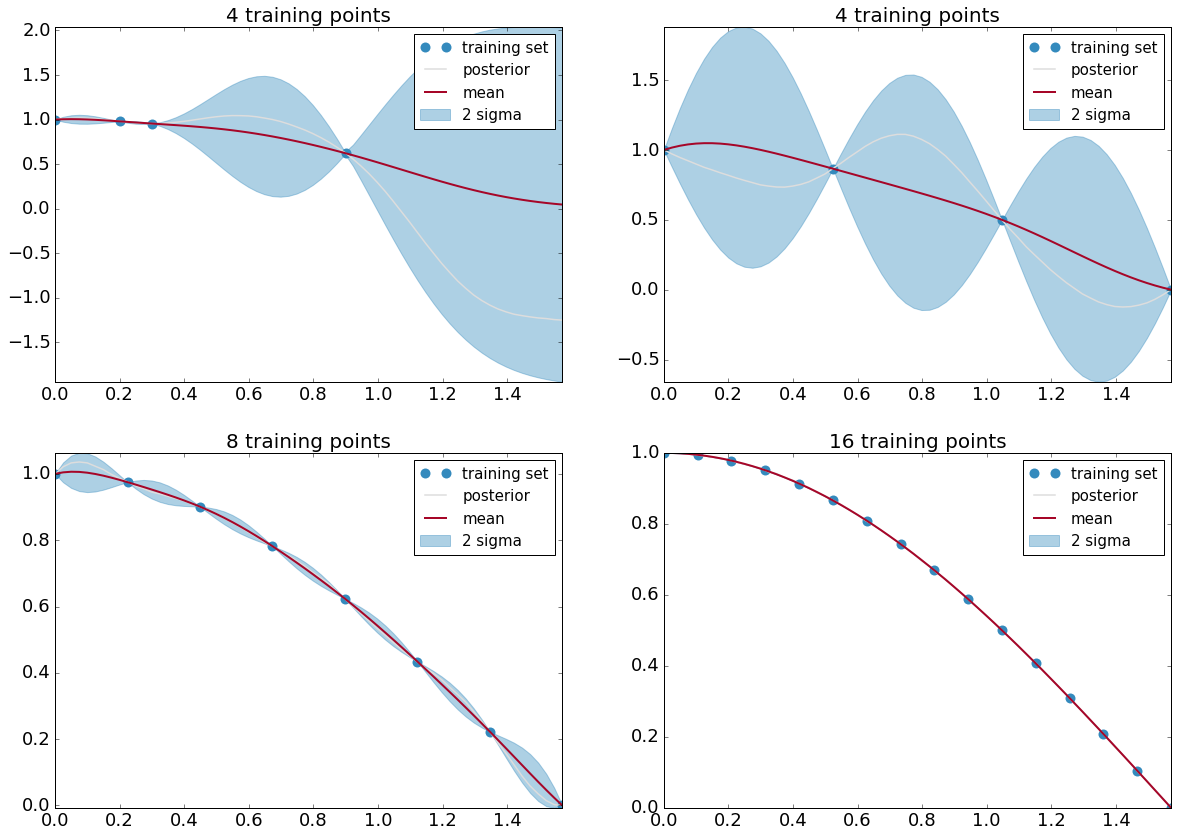

In [3]:
#parameters
nS, Lx = 64, 0.5*np.pi
iP, nP  = 10.0 , 1  
xS = np.linspace(0, Lx, nS)
yS = xS*0;  yP = xS*0 
K  = 0; Ks=0; Kss=0; mu=0;sd=0; 
f = plt.figure(figsize=(20, 14));   


## Training set #1
nT = 4
xT = np.array([0, .2, .3, .9])
yT = np.cos(xT)

sp =  f.add_subplot(2,2,1);
plt.title('%s training points'%nT, fontsize=20)
gp = GPR(nS, nT, iP, nP, Lx, xS, xT, yS, yT, yP, K, Ks, Kss, mu,sd)
gp.runGPR()


## Training set #2
nT = 4
xT = np.linspace(0, Lx, nT); 
yT = np.cos(xT)

sp =  f.add_subplot(2,2,2);
plt.title('%s training points'%nT, fontsize=20)
gp = GPR(nS, nT, iP, nP, Lx, xS, xT, yS, yT, yP, K, Ks, Kss, mu,sd)
gp.runGPR()


## Training set #3
nT = 8
xT = np.linspace(0, Lx, nT); 
yT = np.cos(xT)

sp =  f.add_subplot(2,2,3);
plt.title('%s training points'%nT, fontsize=20)
gp = GPR(nS, nT, iP, nP, Lx, xS, xT, yS, yT, yP, K, Ks, Kss, mu,sd)
gp.runGPR()


## Training set #4
nT = 16
xT = np.linspace(0, Lx, nT); 
yT = np.cos(xT)

sp =  f.add_subplot(2,2,4);
plt.title('%s training points'%nT, fontsize=20)
gp = GPR(nS, nT, iP, nP, Lx, xS, xT, yS, yT, yP, K, Ks, Kss, mu,sd)
gp.runGPR()

We note that the prediction improves as more training points are used. Also, note that same number of training points is used in two panels of the first row. In the second panel, these points are evenly spaced. This results in a good fit in one part of the data, where training points are evenly spaced, while a bad fit in the other.

Let's now have a look at a data obtained from a function which has more wiggles.

## Example 2: $\frac{\sin x}{x}$

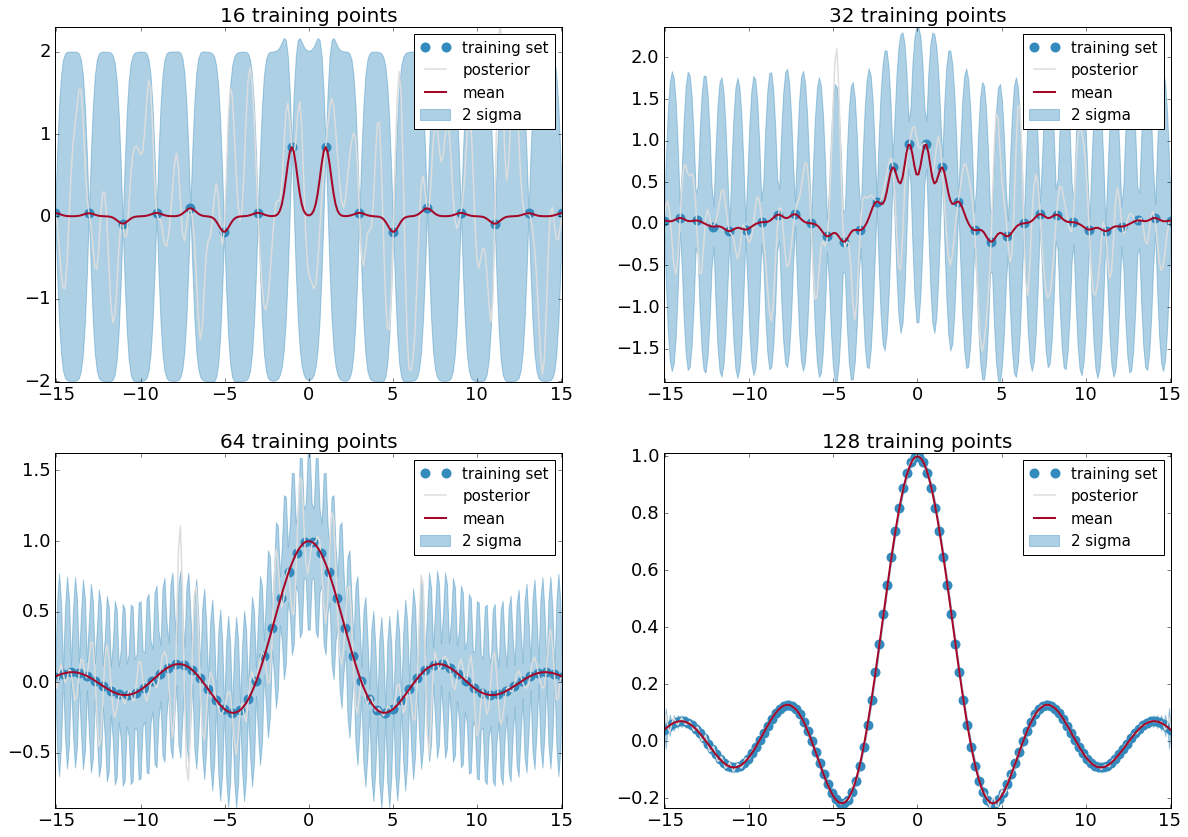

In [4]:
#parameters
nS, Lx = 256, 4.8*np.pi
iP, nP  = 10.0 , 1  
xS = np.linspace(-Lx, Lx, nS)
yS = xS*0;  yP = xS*0 
K  = 0; Ks=0; Kss=0; mu=0;sd=0; 
f = plt.figure(figsize=(20, 14));  


## Training set #1
nT = 16
xT = np.linspace(-Lx, Lx, nT)
yT = np.sin(xT)/xT

sp =  f.add_subplot(2,2,1);
plt.title('%s training points'%nT, fontsize=20)
gp = GPR(nS, nT, iP, nP, Lx, xS, xT, yS, yT, yP, K, Ks, Kss, mu,sd)
gp.runGPR()


## Training set #2
nT = 32
xT = np.linspace(-Lx, Lx, nT)
yT = np.sin(xT)/xT

sp =  f.add_subplot(2,2,2);
plt.title('%s training points'%nT, fontsize=20)
gp = GPR(nS, nT, iP, nP, Lx, xS, xT, yS, yT, yP, K, Ks, Kss, mu,sd)
gp.runGPR()


## Training set #3
nT = 64
xT = np.linspace(-Lx, Lx, nT)
yT = np.sin(xT)/xT

sp =  f.add_subplot(2,2,3);
plt.title('%s training points'%nT, fontsize=20)
gp = GPR(nS, nT, iP, nP, Lx, xS, xT, yS, yT, yP, K, Ks, Kss, mu,sd)
gp.runGPR()


## Training set #4
nT = 128
xT = np.linspace(-Lx, Lx, nT)
yT = np.sin(xT)/xT

sp =  f.add_subplot(2,2,4);
plt.title('%s training points'%nT, fontsize=20)
gp = GPR(nS, nT, iP, nP, Lx, xS, xT, yS, yT, yP, K, Ks, Kss, mu,sd)
gp.runGPR()

### References
* C. E. Rasmussen and C. K. I. Williams. Gaussian processes for machine learning, MIT press Cambridge, 2006.
* K. P. Murphy. Machine Learning: A Probabilistic Perspective (Adaptive Computation and Machine Learning series), MIT press Cambridge, 2012.
* D. J. C. MacKay. Information theory, inference and learning algorithms. Cambridge University Press, 2003.
* D. Sivia and J. Skilling. Data analysis: A Bayesian tutorial, Oxford University Press, Oxford, 2006.
* http://www.gaussianprocess.org/